## Gaussian Process Regression

In this notebook, we investigate Gaussian Process Regression and partially follow [1] and [2]. But first, let's define what a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) is.

**Definition**: A *Gaussian process* is a collection of random variables such that any finite subset of which have a joint Gaussian distribution.

Let the **prior** on the regression function be a Gaussian process (i.e. we define a **prior over functions**). A Gaussian process $f(\mathbf{x})$ is completely specified by its mean function $\mu(\mathbf{x})$ and covariance function $\kappa(\mathbf{x}, \mathbf{x'})$. We denote such a Gaussian process as $$f(\mathbf{x}) \sim GP(\mu(\mathbf{x}), \kappa(\mathbf{x}, \mathbf{x'})).$$

 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

Let's define a kernel function $$\kappa(x, x')= \exp(-\frac{\lVert x - x' \lVert_{2}^{2}}{2}).$$

In [2]:
kappa = lambda x, y: rbf_kernel(x.reshape(-1, 1), y.reshape(-1, 1), gamma=.5)

This kernel maps *close* points to numbers close to $1$ and points that are distant to numbers close to $0$. This fact is important as we shall see below.

### Plotting the prior

Sampling from the prior amounts to sampling from a Gaussian process. To sample from a Gaussian process, one needs to simulate a finite multivariate Gaussian distribution with a given covariance matrix (we can assume that the mean is null without loss of generality).

Let's assume that we want to sample from $$f(\mathbf{x}) \sim GP(\mathbf{0}, \mathbf{\Sigma})$$ where $\mathbf{x^T} = (x_{1}, ..., x_{n})$ and $\Sigma_{ij} = \kappa(x_{i}, x_{j})$, we can factorize the covariance matrix using the Cholesky decomposition, i.e. find a lower triangular matrix $\mathbf{L}$ such that $$\Sigma = \mathbf{LL^T}$$ and simply sample from our desired multivariate Gaussian distribution by computing $$\mathbf{LZ}$$ where $\mathbf{Z^T}=(Z_1, ..., Z_n)$ and $Z_1$, ..., $Z_n$ are i.i.d. standard Gaussian random variables.

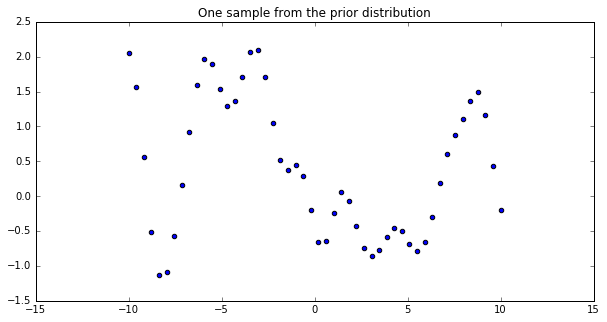

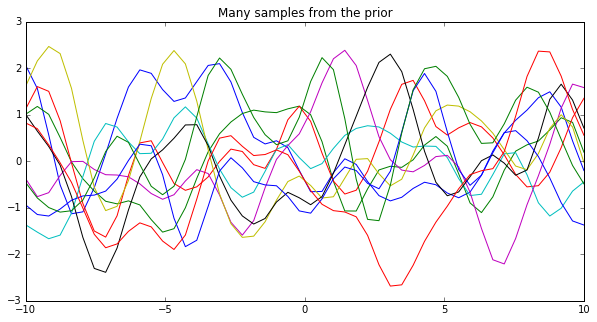

In [3]:
n=50
m=10
X = np.linspace(-10, 10, num=n)
kappa_ = kappa(X, X)
L = np.linalg.cholesky(kappa_)
Z = np.random.normal(size=(n,m))
prior = np.dot(L, Z)
plt.scatter(X, prior[:, 0])
plt.title('One sample from the prior distribution')
plt.show()
plt.plot(X, prior)
plt.title('Many samples from the prior');

On the first plot, we observe some regularity in the sequence of points that is due to the covariance matrix. The covariance matrix imposes on each point some dependance. More precisely, each point is a linear combination of the points that precedes him plus some random normal variable. Indeed, keeping the same notations as before, $$f(x_{i}) = \sum_{j=1}^i L_{ij} z_j,$$ where $z_j$ is one sample from $Z_j$.

The kernel $\kappa$ as defined above forces close points to have a high correlation, thus imposing local regularity to the points/functions as we saw on the plots.


Let's see what happens if we use an identity covariance matrix, i.e. a Gaussian with its components independent.

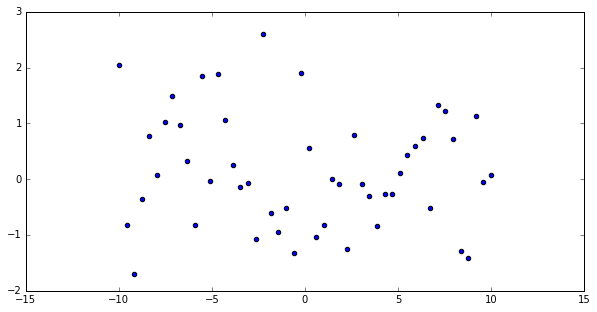

In [4]:
kappa_ = np.identity(n)
prior = np.dot(kappa_, Z)
plt.scatter(X, prior[:, 0]);

When using an identity covariance matrix, each point follows a normal distribution that is independent from all the others. Unlike on the previous graph where we observed some regularity, here, each point is independent from the rest.

### Noise-free observations

Let's now move to the problem of regression. Suppose we have a training set $D=\{(x_1, f_1), ..., (x_n, f_n)\}$ where $f_i = f(x_i)$ and $\mathbf{f}=f(\mathbf{x})$. Given a test set $\mathbf{x_\star}$, we want to predict $f_\star = f(\mathbf{x}_\star)$.

The joint distribution of $\mathbf{f}$ and $\mathbf{f}_\star$ has the following form

$$
\begin{pmatrix}
\mathbf{f} \\
 \mathbf{f_\star} \\
\end{pmatrix} \sim   \mathcal{N} \begin{pmatrix} \begin{pmatrix}
\mathbf{\mu} \\
 \mathbf{\mu_\star} \\
\end{pmatrix}, \begin{pmatrix}
\mathbf{K} &  \mathbf{K_\star}\\
\mathbf{K_\star^T} & \mathbf{K_{\star\star}}
\end{pmatrix} \end{pmatrix}
$$

where $\mathbf{K}=\kappa(\mathbf{x}, \mathbf{x})$, $\mathbf{K_\star}=\kappa(\mathbf{x}, \mathbf{x_\star})$, and $\mathbf{K_{\star\star}}=\kappa(\mathbf{x_\star}, \mathbf{x_\star})$.

From this joint distribution, we get the posterior distribution

$$p(\mathbf{f_\star}|\mathbf{x_\star}, \mathbf{x}, \mathbf{f}) = \mathcal{N}(\mathbf{f_\star} | \mathbf{\mu_\star}, \Sigma_\star)$$

where 

$$
\begin{align*}
\mathbf{\mu_\star} & = \mu(\mathbf{x_\star}) + \mathbf{K_\star}^T \mathbf{K}^{-1}(\mathbf{f}-\mu(\mathbf{x}))\\
\Sigma_\star & = \mathbf{K_{\star\star}} - \mathbf{K_\star}^T \mathbf{K}^{-1} \mathbf{K_\star}.
\end{align*}
$$

As before, to sample from the posterior we factorize the covariance matrix of the posterior using the Cholesky decomposition. We plot the posterior below.

In [5]:
f = lambda x: np.sin(0.9*x).flatten() # real function that we try to approximate

# the training set
n = 5
X = np.random.uniform(-5, 5, size=n)
fX = f(X)

# the testing set
n_star = 50
X_star = np.linspace(-5, 5, num=n_star)

In [6]:
def get_posterior(X, y, X_star, kappa, sigma=0):
    """
    Returns the posterior parameters. For simplicity, we consider mu(x) = 0 which is common since
    the GP is flexible enough to model the mean arbitrarily well (cf. [2] section 15.2).
    
    Args:
        X: a `numpy array` representing the training data.
        y: a `numpy array` representing the observations, either noisy or not.
        X_star: a `numpy array` representing the testing data i.e. the
            point at which to evaluate the regression.
        kappa: a function representing the positive definite kernel.
        sigma: a `float`. A positive real representing the noise in the data, i.e.
            y_i = f(x_i) + eps where eps ~ N(0, sigma^2)
            
    Returns:
        mu_star: a `numpy array` equal to the mean of the posterior distribution.
        L_sigma: a `numpy array` equal to sigma_posterior = L_sigma L_sigma.T where
            sigma_posterior is the covariance matrix of the posterior distribution.
        std: a `numpy array` containing the variances of the marginal distributions
            of the posterior.
        alpha: a `numpy array` equal to (K + sigma^2I)^{-1}y.

    """
    # defining the covariance matrix
    K = kappa(X, X) + sigma ** 2 * np.identity(n)
    K_star = kappa(X_star, X)
    K_star_star = kappa(X_star, X_star)

    # calculating the parameters of the posterior, i.e. mu_star and sigma_star
    L_K = np.linalg.cholesky(K)
    a = np.linalg.solve(L_K, y)
    alpha = np.linalg.solve(L_K.T, a)
    mu_star = np.dot(K_star, alpha) # mean of the posterior
    v = np.linalg.solve(L_K, K_star.T)
    sigma_star = K_star_star - np.dot(v.T, v) # covariance of the posterior

    # variance of marginal distribution
    # this is useful for the confidence interval
    std2 = np.diag(sigma_star)
    std = np.sqrt(std2)

    # Factorize the posterior covariance matrix in order to sample from it using Cholesky decomposition
    L_sigma = np.linalg.cholesky(sigma_star + 1e-6 * np.eye(sigma_star.shape[0])) # we add 1e-6 for numerical stability
    return mu_star, L_sigma, std, alpha

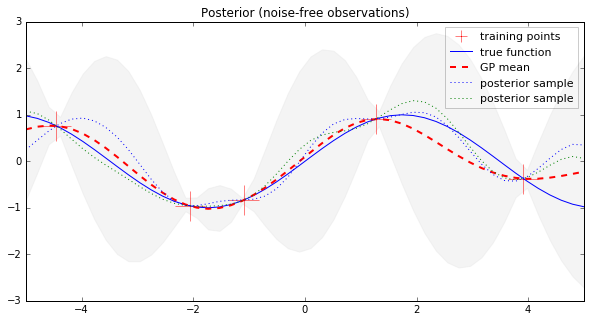

In [7]:
mu_star, L_star, std, alpha = get_posterior(X, fX, X_star, kappa, sigma=0)

# Sample m path from the posterior
m = 2
f_posterior = np.expand_dims(mu_star, axis=1) + np.dot(L_star, np.random.normal(size=(n_star, m)))

plt.plot(X, fX, 'r+', ms=30, label='training points')
plt.plot(X_star, f(X_star), 'b-', label='true function')
plt.plot(X_star, mu_star, 'r--', lw=2, label='GP mean')
plt.plot(X_star, f_posterior, ':', label='posterior sample')
plt.gca().fill_between(X_star.flat, mu_star - 3 * std, mu_star + 3 * std, color="#dddddd", alpha=.3)
plt.title('Posterior (noise-free observations)')
plt.xlim((-5, 5))
plt.legend(fontsize=11, numpoints=1, markerscale=.4, framealpha=.2);

### Predicting one point

To fix ideas, let's try to predict the value of $-2$, i.e. $f(-2)$.

In [8]:
def predict_one_point(x):
    """
    Predict one point using equation (2.27) from [1].
    """
    return np.dot(kappa(np.array([x]), X), alpha)[0]

In [9]:
predict_one_point(-2)

-0.98050219071607547

### Noisy observations

The case of noisy observations is very similar to the noise-free case. Instead of having $D=\{(x_1, f_1), ..., (x_n, f_n)\}$ with $f_i = f(x_i)$, we have $D=\{(x_1, y_1), ..., (x_n, y_n)\}$ where $y_i = f(x_i) + \epsilon$ and $\epsilon \sim \mathcal{N}(0, \sigma^2)$. The covariance of the observed noisy responses is given by

$$\textrm{cov}(y_i, y_j) = \kappa(x_i, x_j) + \sigma^2\delta_{ij}$$ i.e.

$$K_y \triangleq \textrm{cov}(\mathbf{y}) = \kappa(\mathbf{x}, \mathbf{x}) + \sigma^2\textrm{I}_n.$$

Thus, the joint distribution becomes

$$\begin{pmatrix}
\mathbf{y} \\
 \mathbf{f_\star} \\
\end{pmatrix} \sim   \mathcal{N} \begin{pmatrix} \begin{pmatrix}
\mathbf{\mu} \\
 \mathbf{\mu_\star} \\
\end{pmatrix}, \begin{pmatrix}
\mathbf{K}_y &  \mathbf{K_\star}\\
\mathbf{K_\star^T} & \mathbf{K_{\star\star}}
\end{pmatrix} \end{pmatrix}$$

and the posterior is the same as in equation as in the noise-free case where we replace $\mathbf{K}$ by $\mathbf{K}_y$.

We note that now, the model is not required to interpolate the data exactly as in the noise-free case.

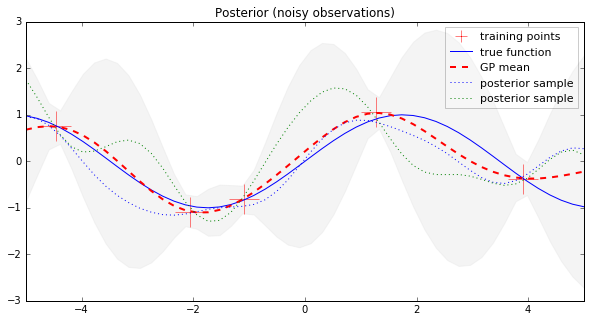

In [10]:
sigma = .1
y = fX + sigma * np.random.normal(size=n)
mu_star, L_star, std, _ = get_posterior(X, y, X_star, kappa, sigma=sigma)

# Sample m path from the posterior
m = 2
f_posterior = np.expand_dims(mu_star, axis=1) + np.dot(L_star, np.random.normal(size=(n_star, m)))

plt.plot(X, y, 'r+', ms=30, label='training points')
plt.plot(X_star, f(X_star), 'b-', label='true function')
plt.plot(X_star, mu_star, 'r--', lw=2, label='GP mean')
plt.plot(X_star, f_posterior, ':', label='posterior sample')
plt.gca().fill_between(X_star.flat, mu_star - 3 * std, mu_star + 3 * std, color="#dddddd", alpha=.3)
plt.title('Posterior (noisy observations)')
plt.xlim((-5, 5))
plt.legend(fontsize=11, numpoints=1, markerscale=.4, framealpha=.2);

## References

[1] C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006.

[2] Murphy, Kevin P. Machine Learning: A Probabilistic Perspective, the MIT Press, 2012.